<a href="https://colab.research.google.com/github/Umair-Syed/Social_Network_Analysis/blob/main/Social_Network_Assignment_4_(Sentiment_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Name: Syed Umair Andrabi**

### **Reg. No: 22MCB0015**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DATA SETS/twitter_sentiment/twitter_sentiment_training_data.csv", header=None)
data = data.iloc[:, [-1, 0]]
header = ["text", "sentiment"]
data.columns = header
data['sentiment'] = data['sentiment'].map({0: "negative", 2: "neutral", 4: "positive"})
data

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative
1,is upset that he can't update his Facebook by ...,negative
2,@Kenichan I dived many times for the ball. Man...,negative
3,my whole body feels itchy and like its on fire,negative
4,"@nationwideclass no, it's not behaving at all....",negative
...,...,...
19995,Just woke up. Having no school is the best fee...,positive
19996,TheWDB.com - Very cool to hear old Walt interv...,positive
19997,Are you ready for your MoJo Makeover? Ask me f...,positive
19998,Happy 38th Birthday to my boo of alll time!!! ...,positive


sentiment: (0 = negative, 2 = neutral, 4 = positive)

In [ ]:
data.describe()

,text,sentiment
count,20000,20000
unique,19953,2
top,At work,negative
freq,5,10000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       20000 non-null  object
 1   sentiment  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


## **Preprocessing data**

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Initializing the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Function to clean the text"""
    # Removing URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Removing twitter handles (@user)
    text = re.sub(r'\@\w+','', text)
    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Removing special characters
    text = re.sub(r'\W', ' ', text)
    # Removing numbers
    text = re.sub(r'\s+[0-9]+', ' ', text)
    # Removing single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Removing multiple spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Converting to lowercase
    text = text.lower()
    # Lemmatization
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)

    # removing stop words
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    
    # Joining the cleaned words and returning as text
    text = ' '.join(words)

    return text


# You can apply the cleaning function to your text column like this:
data_clean = data.copy()
data_clean['text'] = data_clean['text'].apply(clean_text)
data_clean.to_csv('clean_data.csv')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print(f"Original: {data['text'][0]}")
print(f"Original: {data_clean['text'][0]}")

Original: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Original: thats bummer shoulda got david carr third day


### **Visualizing the data**

In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


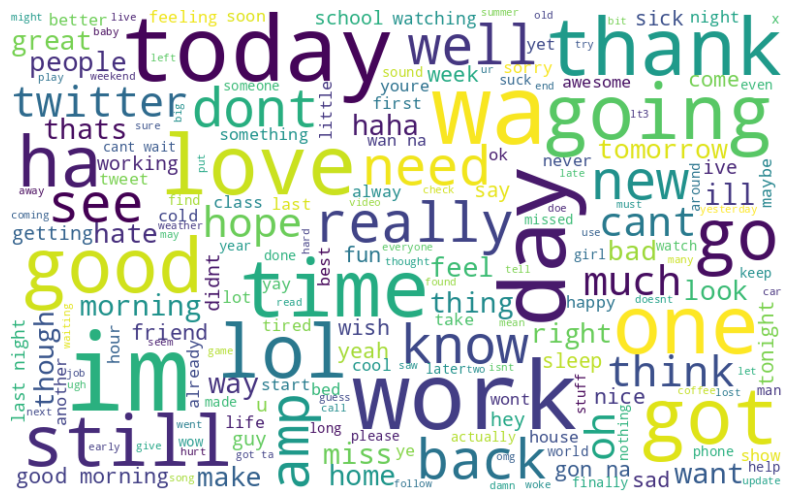

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all rows of the text column into a single string
all_words = ' '.join([text for text in data_clean['text']])

# Create the word cloud object
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(all_words)

# Display the generated image
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


# **1. Sentiment Analysis Algorithms ('TextBlob', 'VADER', 'Logistic Regression', 'Naive Bayes', 'Random Forest')**

In [ ]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

### **1. TextBlob**

In [ ]:
def analyze_sentiment_textblob(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

data_clean['sentiment_textblob'] = data_clean['text'].apply(analyze_sentiment_textblob)
data_clean.head()

,text,sentiment,sentiment_textblob
0,thats bummer shoulda got david carr third day,negative,neutral
1,upset cant update facebook texting might cry r...,negative,neutral
2,dived many time ball managed save rest go bound,negative,positive
3,whole body feel itchy like fire,negative,positive
4,behaving im mad cant see,negative,negative


### **2. TextVADER**

In [ ]:
# Download VADER lexicon 
nltk.download('vader_lexicon')
# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text):
    sentiment_scores = sia.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

data_clean['sentiment_vader'] = data_clean['text'].apply(analyze_sentiment_vader)
data_clean.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,text,sentiment,sentiment_textblob,sentiment_vader
0,thats bummer shoulda got david carr third day,negative,neutral,negative
1,upset cant update facebook texting might cry r...,negative,neutral,negative
2,dived many time ball managed save rest go bound,negative,positive,positive
3,whole body feel itchy like fire,negative,positive,negative
4,behaving im mad cant see,negative,negative,negative


## **3. Logistic Regression**

In [ ]:
# Convert text into a matrix of TF-IDF features
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(data_clean['text'])

# Encode the labels
encoder = LabelEncoder()
labels = encoder.fit_transform(data_clean['sentiment'])

# Split the data into train and test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# Train the Logistic Regression model
lr = LogisticRegression()
lr.fit(features_train, labels_train)

LogisticRegression()

In [ ]:
# Predict the sentiment on test set
labels_pred = lr.predict(features_test)

# Print accuracy of the model
print("Accuracy: ", accuracy_score(labels_test, labels_pred))

# Add predictions to the DataFrame
data_clean['sentiment_lr'] = encoder.inverse_transform(lr.predict(features))
data_clean.head()

Accuracy:  0.74775


,text,sentiment,sentiment_textblob,sentiment_vader,sentiment_lr
0,thats bummer shoulda got david carr third day,negative,neutral,negative,positive
1,upset cant update facebook texting might cry r...,negative,neutral,negative,negative
2,dived many time ball managed save rest go bound,negative,positive,positive,negative
3,whole body feel itchy like fire,negative,positive,negative,negative
4,behaving im mad cant see,negative,negative,negative,negative


## **4. Naive-Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the Naive Bayes model
nb = MultinomialNB()
nb.fit(features_train, labels_train)

# Predict the sentiment on test set
labels_pred_nb = nb.predict(features_test)

# Add predictions to the DataFrame
data_clean['sentiment_nb'] = encoder.inverse_transform(nb.predict(features))
data_clean.head()

,text,sentiment,sentiment_textblob,sentiment_vader,sentiment_lr,sentiment_nb
0,thats bummer shoulda got david carr third day,negative,neutral,negative,positive,positive
1,upset cant update facebook texting might cry r...,negative,neutral,negative,negative,negative
2,dived many time ball managed save rest go bound,negative,positive,positive,negative,negative
3,whole body feel itchy like fire,negative,positive,negative,negative,negative
4,behaving im mad cant see,negative,negative,negative,negative,negative


## **5. Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_train, labels_train)

# Predict the sentiment on test set
labels_pred_rf = rf.predict(features_test)

# Add predictions to the DataFrame
data_clean['sentiment_rf'] = encoder.inverse_transform(rf.predict(features))
data_clean

,text,sentiment,sentiment_textblob,sentiment_vader,sentiment_lr,sentiment_nb,sentiment_rf
0,thats bummer shoulda got david carr third day,negative,neutral,negative,positive,positive,positive
1,upset cant update facebook texting might cry r...,negative,neutral,negative,negative,negative,negative
2,dived many time ball managed save rest go bound,negative,positive,positive,negative,negative,negative
3,whole body feel itchy like fire,negative,positive,negative,negative,negative,negative
4,behaving im mad cant see,negative,negative,negative,negative,negative,negative
...,...,...,...,...,...,...,...
19995,woke school best feeling ever,positive,positive,positive,negative,negative,positive
19996,thewdbcom cool hear old walt interview,positive,positive,positive,positive,positive,positive
19997,ready mojo makeover ask detail,positive,positive,positive,positive,positive,positive
19998,happy th birthday boo alll time tupac amaru sh...,positive,positive,positive,positive,positive,negative


# **Comparing all five algorithms**

In [ ]:
from tabulate import tabulate

# Accuracy scores
accuracy_textblob = accuracy_score(data_clean['sentiment'], data_clean['sentiment_textblob'])
accuracy_vader = accuracy_score(data_clean['sentiment'], data_clean['sentiment_vader'])
accuracy_lr = accuracy_score(data_clean['sentiment'], data_clean['sentiment_lr'])
accuracy_nb = accuracy_score(data_clean['sentiment'], data_clean['sentiment_nb'])
accuracy_nb = accuracy_score(data_clean['sentiment'], data_clean['sentiment_nb'])
accuracy_rf = accuracy_score(data_clean['sentiment'], data_clean['sentiment_rf'])

# Data for the table
table_data = [
    ["TextBlob", accuracy_textblob],
    ["VADER", accuracy_vader],
    ["Logistic Regression", accuracy_lr],
    ["Naive Bayes", accuracy_nb],
    ["Random Forest", accuracy_rf]
]

# Table headers
headers = ["Sentiment Analysis Method", "Accuracy"]

# Generate the table
table = tabulate(table_data, headers, tablefmt="fancy_grid")

# Print the table
print(table)


╒═════════════════════════════╤════════════╕
│ Sentiment Analysis Method   │   Accuracy │
╞═════════════════════════════╪════════════╡
│ TextBlob                    │    0.42955 │
├─────────────────────────────┼────────────┤
│ VADER                       │    0.49815 │
├─────────────────────────────┼────────────┤
│ Logistic Regression         │    0.83575 │
├─────────────────────────────┼────────────┤
│ Naive Bayes                 │    0.8545  │
├─────────────────────────────┼────────────┤
│ Random Forest               │    0.9438  │
╘═════════════════════════════╧════════════╛


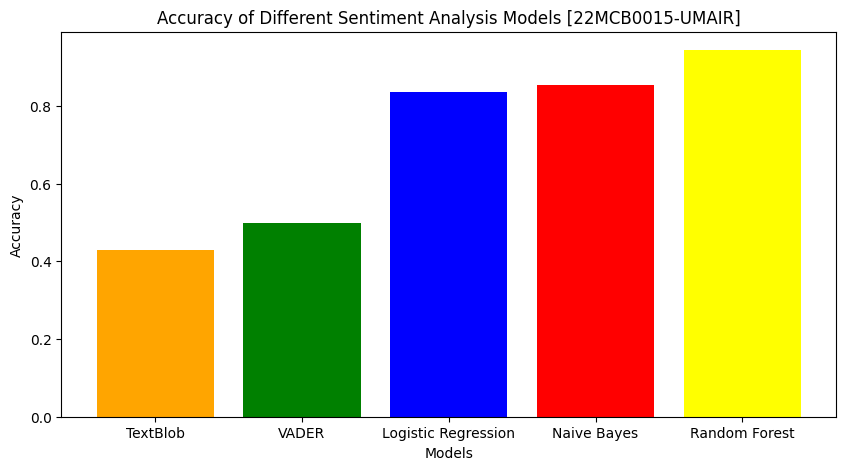

In [ ]:
import matplotlib.pyplot as plt

models = ['TextBlob', 'VADER', 'Logistic Regression', 'Naive Bayes', 'Random Forest']
accuracies = [accuracy_textblob, accuracy_vader, accuracy_lr, accuracy_nb, accuracy_rf]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['orange', 'green', 'blue', 'red', 'yellow'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Sentiment Analysis Models [22MCB0015-UMAIR]")
plt.show()


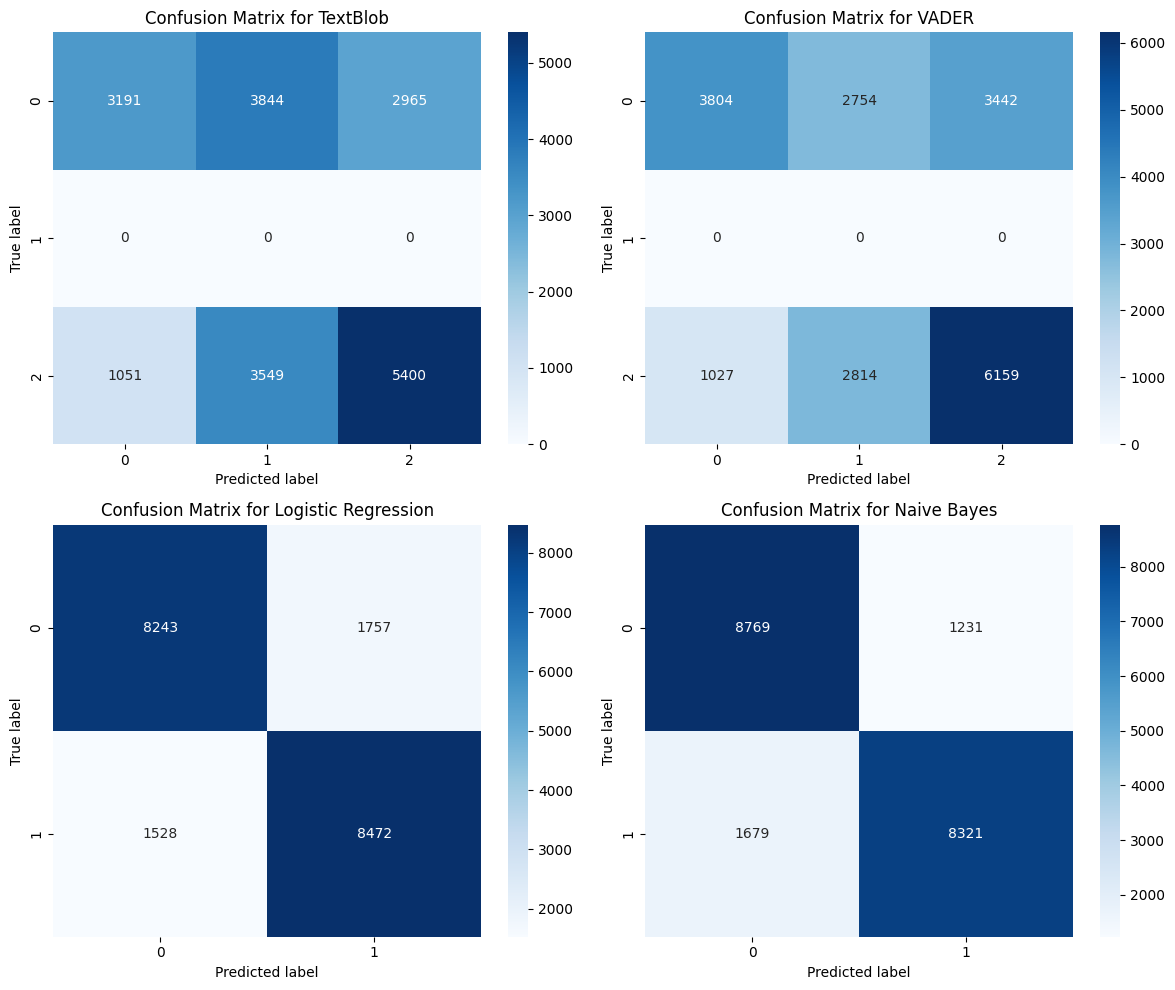

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix for ' + title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot confusion matrices
plot_confusion_matrix(axs[0, 0], data_clean['sentiment'], data_clean['sentiment_textblob'], 'TextBlob')
plot_confusion_matrix(axs[0, 1], data_clean['sentiment'], data_clean['sentiment_vader'], 'VADER')
plot_confusion_matrix(axs[1, 0], data_clean['sentiment'], data_clean['sentiment_lr'], 'Logistic Regression')
plot_confusion_matrix(axs[1, 1], data_clean['sentiment'], data_clean['sentiment_nb'], 'Naive Bayes')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


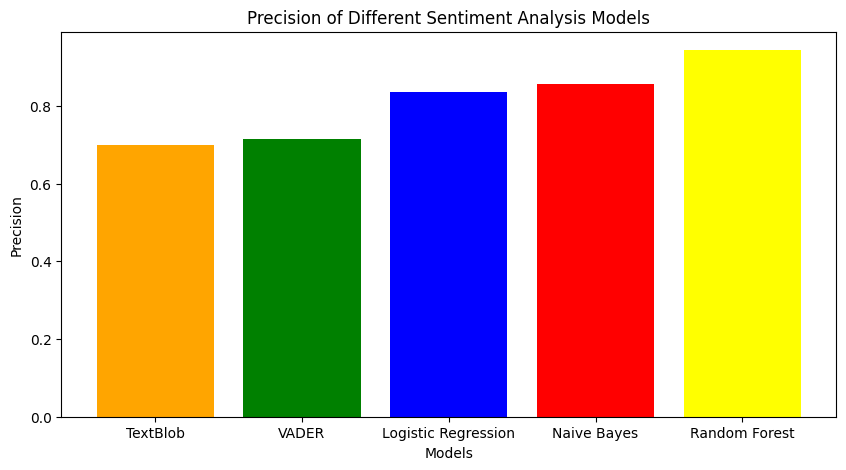

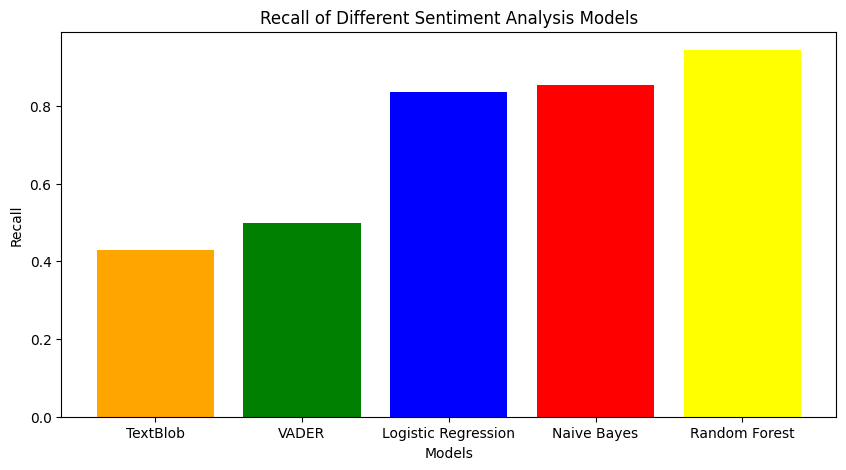

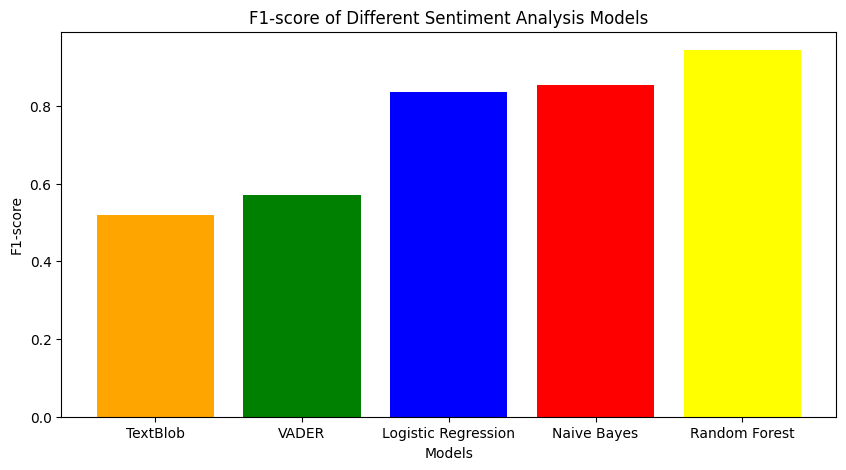

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Calculate metrics for each model
def calculate_metrics(y_true, y_pred):
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return precision, recall, f1_score

# Calculate metrics for TextBlob
precision_textblob, recall_textblob, f1_score_textblob = calculate_metrics(data_clean['sentiment'], data_clean['sentiment_textblob'])

# Calculate metrics for VADER
precision_vader, recall_vader, f1_score_vader = calculate_metrics(data_clean['sentiment'], data_clean['sentiment_vader'])

# Calculate metrics for Logistic Regression
precision_lr, recall_lr, f1_score_lr = calculate_metrics(data_clean['sentiment'], data_clean['sentiment_lr'])

# Calculate metrics for Naive Bayes
precision_nb, recall_nb, f1_score_nb = calculate_metrics(data_clean['sentiment'], data_clean['sentiment_nb'])

# Calculate metrics for Random Forest
precision_rf, recall_rf, f1_score_rf = calculate_metrics(data_clean['sentiment'], data_clean['sentiment_rf'])

# Data for the precision bar plot
precisions = [precision_textblob, precision_vader, precision_lr, precision_nb, precision_rf]

# Plot precision bar plot
plt.figure(figsize=(10, 5))
plt.bar(models, precisions, color=['orange', 'green', 'blue', 'red', 'yellow'])
plt.xlabel("Models")
plt.ylabel("Precision")
plt.title("Precision of Different Sentiment Analysis Models")
plt.show()

# Data for the recall bar plot
recalls = [recall_textblob, recall_vader, recall_lr, recall_nb, recall_rf]

# Plot recall bar plot
plt.figure(figsize=(10, 5))
plt.bar(models, recalls, color=['orange', 'green', 'blue', 'red', 'yellow'])
plt.xlabel("Models")
plt.ylabel("Recall")
plt.title("Recall of Different Sentiment Analysis Models")
plt.show()

# Data for the F1-score bar plot
f1_scores = [f1_score_textblob, f1_score_vader, f1_score_lr, f1_score_nb, f1_score_rf]

# Plot F1-score bar plot
plt.figure(figsize=(10, 5))
plt.bar(models, f1_scores, color=['orange', 'green', 'blue', 'red', 'yellow'])
plt.xlabel("Models")
plt.ylabel("F1-score")
plt.title("F1-score of Different Sentiment Analysis Models")
plt.show()


# **2. BI-LSTM with word2vec word embedding**


In [ ]:
!pip install gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# TensorFlow and tf.keras
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
import os

# Helper libraries
import numpy as np
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

# Setting up TPU strategy
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

# Define the parameters
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# Convert text to sequences
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data_clean['text'])
sequences = tokenizer.texts_to_sequences(data_clean['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Convert labels to binary format
le = LabelEncoder()
labels = le.fit_transform(data_clean['sentiment'])
labels = tf.keras.utils.to_categorical(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Train-validation split
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

# Define the Word2Vec model
word2vec_model = Word2Vec(sentences=data_clean['text'].apply(str.split), vector_size=EMBEDDING_DIM, window=3, min_count=1, epochs=10)

# Prepare the Word2Vec embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    if word in word2vec_model.wv.key_to_index:
        embedding_vector = word2vec_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define the LSTM model
with strategy.scope():
  model = Sequential()
  model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(labels.shape[1], activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Model summary: ', model.summary())

# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Found 20779 unique tokens.
Shape of data tensor: (20000, 1000)
Shape of label tensor: (20000, 2)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         2000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,235,010
Trainable params: 235,010
Non-trainable params: 2,000,000
_________________________________________________________________
Model summary:  None
Epoch 1/5
125/125 [==============================] - 17s 95ms/step - loss: 0.6757 - accuracy: 0.5702 - val_loss: 0.675

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Generate predictions
y_pred_prob = model.predict(x_val)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded labels back to labels
y_val_labels = np.argmax(y_val, axis=1)

# Calculate accuracy
bilstm_accuracy = accuracy_score(y_val_labels, y_pred)
print('Accuracy: %f' % accuracy)

# Calculate precision
bilstm_precision = precision_score(y_val_labels, y_pred, average='binary')
print('Precision: %f' % precision)

# Calculate recall
bilstm_recall = recall_score(y_val_labels, y_pred, average='binary')
print('Recall: %f' % recall)

# Calculate F1 score
bilstm_f1 = f1_score(y_val_labels, y_pred, average='binary')
print('F1 Score: %f' % f1)

# Print confusion matrix
cm = confusion_matrix(y_val_labels, y_pred)
print('Confusion Matrix:\n', cm)


125/125 [==============================] - 4s 21ms/step
Accuracy: 0.593750
Precision: 0.668577
Recall: 0.593750
F1 Score: 0.546638
Confusion Matrix:
 [[1422  550]
 [ 987 1041]]


# **3. Transformer based model with BERT-based word embedding.**


In [ ]:
!pip install transformers

import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Setting up TPU strategy
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

# Use the BERT tokenizer to convert the text to tokens and pad them to the maximum length of 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

data_inputs = data_clean['text'].apply(encode_sentence)

def bert_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  
  for i in range(len(data)):
      encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

MAX_LEN = 512

input_ids,attention_masks = bert_encode(data_clean['text'], MAX_LEN)

# Convert labels to binary format
le = LabelEncoder()
labels = le.fit_transform(data_clean['sentiment'])
labels = tf.keras.utils.to_categorical(labels)

# Train-validation split
train_input_ids, val_input_ids, train_attention_masks, val_attention_masks, y_train, y_val = train_test_split(input_ids,attention_masks,labels, test_size=0.2)

# Define the model
with strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=labels.shape[1])
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([train_input_ids, train_attention_masks], y_train, validation_data=([val_input_ids, val_attention_masks], y_val), epochs=4, batch_size=64)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some laye

Epoch 1/4
250/250 [==============================] - 160s 315ms/step - loss: 0.6524 - accuracy: 0.6814 - val_loss: 0.5183 - val_accuracy: 0.7588
Epoch 2/4
250/250 [==============================] - 63s 252ms/step - loss: 0.5560 - accuracy: 0.7816 - val_loss: 0.6615 - val_accuracy: 0.7310
Epoch 3/4
250/250 [==============================] - 63s 252ms/step - loss: 0.5144 - accuracy: 0.8086 - val_loss: 0.6311 - val_accuracy: 0.7552
Epoch 4/4
250/250 [==============================] - 63s 253ms/step - loss: 0.4960 - accuracy: 0.7964 - val_loss: 0.6959 - val_accuracy: 0.7215


In [ ]:
predictions = model.predict([val_input_ids, val_attention_masks], batch_size=64)
pred_labels = np.argmax(predictions.logits, axis=1)
true_labels = np.argmax(y_val, axis=1)

63/63 [==============================] - 25s 260ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# compute metrics
bert_accuracy = accuracy_score(true_labels, pred_labels)
bert_precision = precision_score(true_labels, pred_labels, average='weighted')
bert_recall = recall_score(true_labels, pred_labels, average='weighted')
bert_f1 = f1_score(true_labels, pred_labels, average='weighted')

# compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

print('Accuracy: ', bert_accuracy)
print('Precision: ', bert_accuracy)
print('Recall: ', bert_accuracy)
print('F1 Score: ', bert_accuracy)
print('Confusion Matrix: \n', cm)


Accuracy:  0.489
Precision:  0.489
Recall:  0.489
F1 Score:  0.489
Confusion Matrix: 
 [[1956    0]
 [2044    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


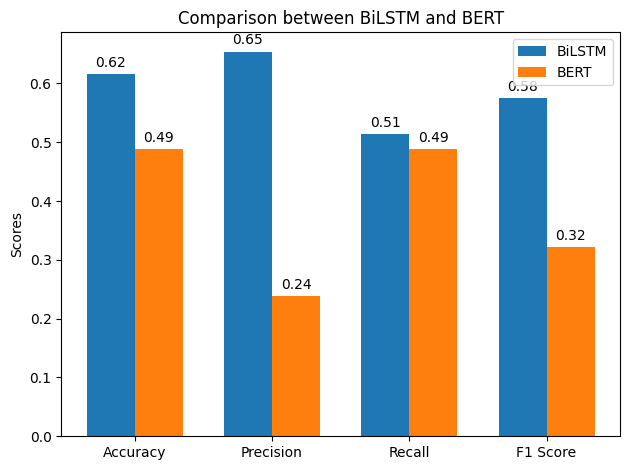

In [ ]:
import matplotlib.pyplot as plt

# metrics for BiLSTM
bilstm_metrics = [bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_f1]

# metrics for BERT
bert_metrics = [bert_accuracy, bert_precision, bert_recall, bert_f1]

# metric labels
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# setting up the plot
x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots()

# creating the bars
rects1 = ax.bar(x - width/2, bilstm_metrics, width, label='BiLSTM')
rects2 = ax.bar(x + width/2, bert_metrics, width, label='BERT')

# adding some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison between BiLSTM and BERT')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# function to attach a label above each bar in rects
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()
